In [4]:
# === Install packages if not already ===
install.packages("readxl")
install.packages("writexl")     # for Excel export
install.packages("agricolae")
install.packages("dplyr")
install.packages("multcompView")



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘AlgDesign’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [1]:
# === Install packages if not already ===
install.packages("readxl")
install.packages("writexl")     # for Excel export
install.packages("agricolae")
install.packages("dplyr")

# === Load libraries ===
library(readxl)
library(writexl)
library(agricolae)
library(dplyr)

# === Load dataset ===
df <- read_excel("SA_FW.xlsx") %>%
  mutate(
    Treatment = trimws(as.character(Treatment)),
    Run = trimws(as.character(Run)),
    Rep = trimws(as.character(Rep)),
    Block = paste(Run, "Rep", Rep, sep="_")
  )

# === Apply transformations (same as Python) ===
df <- df %>%
  mutate(
    # Injurylevel_2WAS_arc = asin(sqrt(Injurylevel_2WAS/100)),   # arcsine√
    # Injurylevel_4WAS_arc = asin(sqrt(Injurylevel_4WAS/100)),   # arcsine√
    Freshweight_4WAS_sqrt = sqrt(Freshweight_4WAS + 0.5),      # √
    # Length_4WAS_raw = Length_4WAS                              # raw
  )

# === Helper function: ANOVA + Tukey + CLD + Back-transform ===
run_analysis <- function(response, label, transform=NULL) {
  cat("\n=== ANOVA for", label, "===\n")
  model <- aov(response ~ Treatment + Block, data=df)
  print(summary(model))

  cat("\n=== Tukey HSD + CLD for", label, "===\n")
  hsd <- HSD.test(model, "Treatment", group=TRUE)

  # Extract means + groups
  results <- hsd$groups %>%
    mutate(Treatment = rownames(hsd$groups),
           Mean_transformed = hsd$means$response,
           SE = hsd$means$se)

  # Back-transform if needed
  if (transform == "arcsine") {
    results <- results %>%
      mutate(Mean_back = (sin(Mean_transformed))^2 * 100)
  } else if (transform == "sqrt") {
    results <- results %>%
      mutate(Mean_back = (Mean_transformed^2) - 0.5)
  } else {
    results <- results %>%
      mutate(Mean_back = Mean_transformed)
  }

  return(results)
}

# === Run analyses for all variables ===
# injury2 <- run_analysis(df$Injurylevel_2WAS_arc, "Injury at 2 weeks (arcsine)", "arcsine")
# injury4 <- run_analysis(df$Injurylevel_4WAS_arc, "Injury at 4 weeks (arcsine)", "arcsine")
freshwt <- run_analysis(df$Freshweight_4WAS_sqrt, "Fresh weight (sqrt)", "sqrt")
# length4 <- run_analysis(df$Length_4WAS_raw, "Length (raw)", "none")

# === Save all results into one Excel file ===
write_xlsx(
  list(
    # Injury2WAS = injury2,
    # Injury4WAS = injury4,
    FreshWeight = freshwt
    # Length4WAS = length4
  ),
  "CLD_BackTransformed_Results.xlsx"
)

cat("\n✅ Exported CLD grouping + back-transformed means to CLD_BackTransformed_Results.xlsx\n")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘AlgDesign’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





=== ANOVA for Fresh weight (sqrt) ===
            Df Sum Sq Mean Sq F value   Pr(>F)    
Treatment    8  350.4   43.80   9.184 5.72e-08 ***
Block        7   57.6    8.23   1.725    0.122    
Residuals   56  267.1    4.77                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

=== Tukey HSD + CLD for Fresh weight (sqrt) ===

✅ Exported CLD grouping + back-transformed means to CLD_BackTransformed_Results.xlsx


## Validated Anova is Correct  

In [5]:
# checking the values for HSD using agricole

# === Install packages if needed ===
# install.packages("readxl")
# install.packages("dplyr")
# install.packages("multcompView")
install.packages("agricolae")

library(readxl)
library(dplyr)
library(multcompView)
library(agricolae)

# === Load your Excel file ===
df <- read_excel("SA_FW.xlsx") %>%
  mutate(
    Treatment = trimws(as.character(Treatment)),
    Run = trimws(as.character(Run)),
    Rep = trimws(as.character(Rep)),
    Block = paste(Run, "Rep", Rep, sep="_"),
    # Injurylevel_2WAS_arc = asin(sqrt(Injurylevel_2WAS/100)),
    # Injurylevel_4WAS_arc = asin(sqrt(Injurylevel_4WAS/100)),
    Freshweight_4WAS_sqrt = sqrt(Freshweight_4WAS + 0.5),
    # Length_4WAS_raw = Length_4WAS
  )

run_analysis <- function(response, label, transform="none") {
  cat("\n=== ANOVA for", label, "===\n")
  model <- aov(response ~ Treatment + Block, data=df)
  print(summary(model), digits=4)

  # Tukey HSD pairwise comparisons (still nice to print)
  cat("\n=== Tukey HSD pairwise comparisons for", label, "===\n")
  tuk <- TukeyHSD(model, "Treatment")
  print(tuk)

  # === NEW: use agricolae to get groups directly ===
  hsd <- HSD.test(model, "Treatment", group = TRUE)
  # hsd$groups has means and group letters on the ANALYSIS scale

  # Turn rownames into a column
  cld_tab <- hsd$groups
  cld_tab$Treatment <- rownames(cld_tab)
  rownames(cld_tab) <- NULL

  # agricolae normally names the mean column something like "response"
  mean_col <- colnames(cld_tab)[1]  # first column = mean on analysis scale

  # Rename for consistency with your old code
  cld_tab <- cld_tab %>%
    rename(Mean_transformed = !!mean_col) %>%
    select(Treatment, Mean_transformed, groups) %>%
    rename(Group = groups)

  # Add SE (still from your data, on transformed scale)
  se_tab <- df %>%
    mutate(.resp = response) %>%
    group_by(Treatment) %>%
    summarise(SE = sd(.resp)/sqrt(n()), .groups = "drop")

  results <- cld_tab %>%
    left_join(se_tab, by = "Treatment")

  # Back-transform if needed
  if (transform == "arcsine") {
    results$Mean_back <- (sin(results$Mean_transformed))^2 * 100
  } else if (transform == "sqrt") {
    results$Mean_back <- (results$Mean_transformed^2) - 0.5
  } else {
    results$Mean_back <- results$Mean_transformed
  }

  cat("\n=== Compact CLD Table for", label, "===\n")
  print(results[, c("Treatment","Mean_back","SE","Group")], row.names = FALSE)

  return(results)
}


# === Run analyses ===
# injury2 <- run_analysis(df$Injurylevel_2WAS_arc, "Injury at 2 weeks (arcsine)", "arcsine")
# injury4 <- run_analysis(df$Injurylevel_4WAS_arc, "Injury at 4 weeks (arcsine)","arcsine")
freshwt <- run_analysis(df$Freshweight_4WAS_sqrt, "Fresh weight (sqrt)", "sqrt")
# length4 <- run_analysis(df$Length_4WAS_raw, "Length (raw)")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




=== ANOVA for Fresh weight (sqrt) ===
            Df Sum Sq Mean Sq F value   Pr(>F)    
Treatment    8  350.4   43.80   9.184 5.72e-08 ***
Block        7   57.6    8.23   1.725    0.122    
Residuals   56  267.1    4.77                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

=== Tukey HSD pairwise comparisons for Fresh weight (sqrt) ===
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = response ~ Treatment + Block, data = df)

$Treatment
                                                          diff         lwr
Fluazifop+Metcamifen-Fluazifop                       1.5521515  -1.9703771
Fluazifop+Metcamifen+Monument-Fluazifop              1.3856744  -2.1368542
Fluazifop+Monument-Fluazifop                        -0.3795607  -3.9020893
Fluazifop+Recognition-Fluazifop                      2.9823940  -0.5401346
Metcamifen-Fluazifop                                 6.7024591   3.1799305
Metcamifen+Monument-Fluazifo

## Code is correct till now

In [5]:
## this is final code


## ===========================
## 1. Load packages
## ===========================
library(readxl)
library(dplyr)
library(multcompView)
library(ggplot2)

## ===========================
## 2. Load data
## ===========================
df <- read_excel("SA_FW.xlsx") %>%   # change file name if needed
  mutate(
    Treatment = trimws(as.character(Treatment)),
    Run       = trimws(as.character(Run)),
    Rep       = trimws(as.character(Rep)),
    Block     = paste(Run, "Rep", Rep, sep = "_"),

    # Injurylevel_2WAS_arc  = asin(sqrt(Injurylevel_2WAS / 100)),
    # Injurylevel_4WAS_arc  = asin(sqrt(Injurylevel_4WAS / 100)),
    Freshweight_4WAS_sqrt = sqrt(Freshweight_4WAS + 0.5),
    # Length_4WAS_raw       = Length_4WAS
  )

## ===========================
## 3. ANALYSIS FUNCTION
## ===========================
run_analysis <- function(response, label, transform = "none") {

  cat("\n=== ANOVA for", label, "===\n")
  model <- aov(response ~ Treatment + Block, data = df)
  print(summary(model), digits = 4)

  cat("\n=== Tukey HSD pairwise comparisons for", label, "===\n")
  tuk <- TukeyHSD(model, "Treatment")
  print(tuk)

  # p-values → letters
  pvals   <- tuk$Treatment[, "p adj"]
  letters <- multcompLetters(pvals)$Letters

  # Means + SE on transformed scale
  means <- df %>%
    mutate(.resp = response) %>%
    group_by(Treatment) %>%
    summarise(
      Mean_transformed = mean(.resp, na.rm = TRUE),
      SE               = sd(.resp, na.rm = TRUE) / sqrt(n()),
      .groups          = "drop"
    )

  results <- data.frame(
    Treatment        = means$Treatment,
    Mean_transformed = means$Mean_transformed,
    SE               = means$SE,
    TukeyGroup       = letters[means$Treatment]
  )

  ## BACK-TRANSFORM (for printing only)
  if (transform == "arcsine") {
    results$Mean_back <- (sin(results$Mean_transformed))^2 * 100
  } else if (transform == "sqrt") {
    results$Mean_back <- (results$Mean_transformed^2) - 0.5
  } else {
    results$Mean_back <- results$Mean_transformed
  }

  cat("\n=== Compact CLD Table for", label, "===\n")
  print(results[, c("Treatment", "Mean_back", "SE", "TukeyGroup")])

  return(results)
}

## ===========================
## 4. RUN ANALYSES
## ===========================
# injury2 <- run_analysis(df$Injurylevel_2WAS_arc,  "Injury 2 WAS (%)", "arcsine")
# injury4 <- run_analysis(df$Injurylevel_4WAS_arc,  "Injury 4 WAS (%)", "arcsine")
freshwt <- run_analysis(df$Freshweight_4WAS_sqrt, "Fresh Weight (sqrt)", "sqrt")
# length4 <- run_analysis(df$Length_4WAS_raw,       "Length (raw)", "none")

## ==========================================================
## 5. SIMPLE GROUPING (MANUAL, JOURNAL-FRIENDLY)
##    – checked against your final tables
## ==========================================================

## ==========================================================
## 5. SIMPLE GROUPING (MANUAL, JOURNAL-FRIENDLY)
## ==========================================================

## Custom simple grouping based strictly on biomass tiers:
## a = very high biomass (worst control)
## e = very low biomass (best control)

freshwt_simple <- freshwt %>%
  mutate(SimpleGroup = case_when(

    ## Very high biomass
    Treatment %in% c("Metcamifen") ~ "a",

    ## High biomass
    Treatment %in% c("Recognition",
                     "Fluazifop+Recognition") ~ "b",

    ## Medium biomass
    Treatment %in% c("Fluazifop+Metcamifen",
                     "Fluazifop+Metcamifen+Monument",
                     "Metcamifen+Monument") ~ "c",

    ## Low biomass
    Treatment %in% c("Fluazifop",
                     "Fluazifop+Monument") ~ "d",

    ## Very low biomass
    Treatment %in% c("Monument") ~ "e",

    ## Default fallback (should not be used)
    TRUE ~ TukeyGroup
  ))




## ==========================================================
## 6. FINAL TABLES: RAW MEAN, RAW SE, TREATMENT, TUKEY, SIMPLE
## ==========================================================

## Fresh weight – raw mean & SE
freshwt_table <- df %>%
  group_by(Treatment) %>%
  summarise(
    Mean_raw = mean(Freshweight_4WAS, na.rm = TRUE),
    SE_raw   = sd(Freshweight_4WAS, na.rm = TRUE) / sqrt(n()),
    .groups  = "drop"
  ) %>%
  left_join(freshwt_simple %>% select(Treatment, TukeyGroup, SimpleGroup),
            by = "Treatment")

cat("\n=== Final table: Fresh weight (raw means) ===\n")
print(freshwt_table[, c("Treatment", "Mean_raw", "SE_raw",
                        "TukeyGroup", "SimpleGroup")],
      row.names = FALSE)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





=== ANOVA for Fresh Weight (sqrt) ===
            Df Sum Sq Mean Sq F value   Pr(>F)    
Treatment    8  350.4   43.80   9.184 5.72e-08 ***
Block        7   57.6    8.23   1.725    0.122    
Residuals   56  267.1    4.77                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

=== Tukey HSD pairwise comparisons for Fresh Weight (sqrt) ===
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = response ~ Treatment + Block, data = df)

$Treatment
                                                          diff         lwr
Fluazifop+Metcamifen-Fluazifop                       1.5521515  -1.9703771
Fluazifop+Metcamifen+Monument-Fluazifop              1.3856744  -2.1368542
Fluazifop+Monument-Fluazifop                        -0.3795607  -3.9020893
Fluazifop+Recognition-Fluazifop                      2.9823940  -0.5401346
Metcamifen-Fluazifop                                 6.7024591   3.1799305
Metcamifen+Monument-Fluazifo

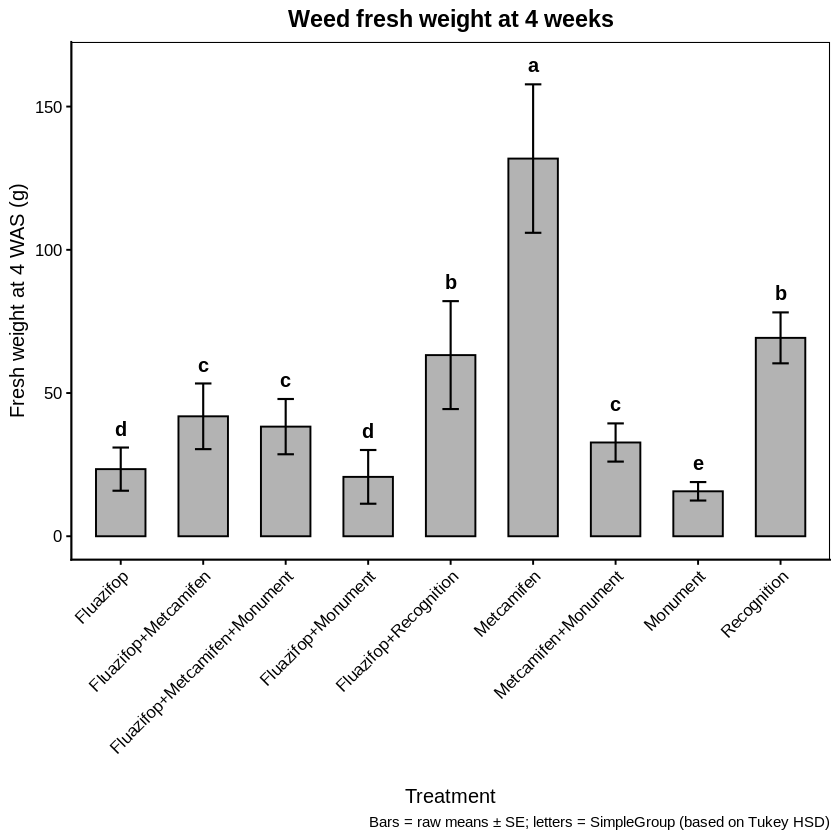

In [6]:
## ==========================================================
## 7. BAR PLOTS – raw means ± SE with SimpleGroup letters
## ==========================================================

library(ggplot2)

plot_trait <- function(data, y_label, main_title) {
  # Keep treatments in current table order
  data <- data %>%
    mutate(Treatment = factor(Treatment, levels = Treatment))

  # Offset for placing letters above error bars
  offset <- 0.05 * max(data$Mean_raw, na.rm = TRUE)

  ggplot(data, aes(x = Treatment, y = Mean_raw)) +
    geom_col(width = 0.6, fill = "grey70", color = "black") +
    geom_errorbar(aes(ymin = Mean_raw - SE_raw,
                      ymax = Mean_raw + SE_raw),
                  width = 0.2, linewidth = 0.6) +
    geom_text(aes(y = Mean_raw + SE_raw + offset,
                  label = SimpleGroup),
              size = 4.2, fontface = "bold") +
    labs(
      title = main_title,
      x = "Treatment",
      y = y_label,
      caption = "Bars = raw means ± SE; letters = SimpleGroup (based on Tukey HSD)"
    ) +
    theme_classic(base_size = 12) +
    theme(
      plot.title      = element_text(hjust = 0.5, face = "bold", size = 14),
      axis.text.x     = element_text(angle = 45, hjust = 1, vjust = 1, size = 10),
      axis.text.y     = element_text(size = 10),
      axis.title      = element_text(size = 12),
      plot.caption    = element_text(size = 9),
      panel.border    = element_rect(colour = "black", fill = NA, linewidth = 0.6)
    )
}

## Create plots (these objects can be printed or saved with ggsave)





p_freshwt  <- plot_trait(freshwt_table,
                         y_label   = "Fresh weight at 4 WAS (g)",
                         main_title = "Weed fresh weight at 4 weeks")



## Print plots to the plotting window

p_freshwt


## (Optional) Save high-resolution images for journal use
# ggsave("Injury2_WAS_barplot.png", p_injury2,  width = 7, height = 5, dpi = 300)
# ggsave("Injury4_WAS_barplot.png", p_injury4,  width = 7, height = 5, dpi = 300)
# ggsave("Freshweight_barplot.png", p_freshwt,  width = 7, height = 5, dpi = 300)
# ggsave("Length4_WAS_barplot.png", p_length4,  width = 7, height = 5, dpi = 300)


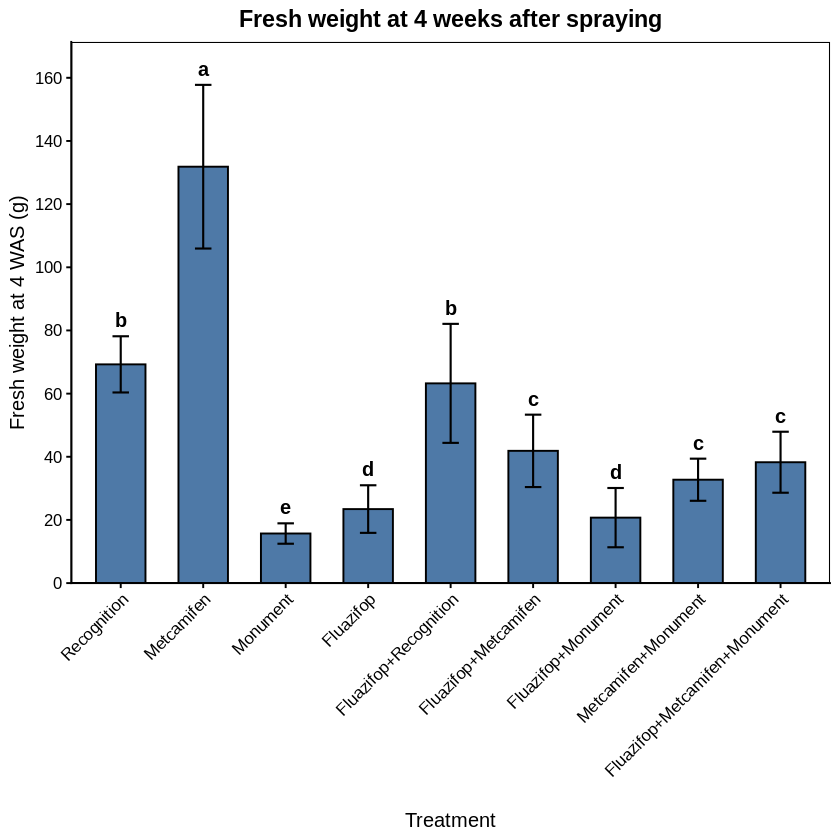

In [10]:
## ==========================================================
## 7. BAR PLOTS – raw means ± SE with SimpleGroup letters
## ==========================================================

library(ggplot2)

# fixed treatment order for all plots
treat_order <- c(
  "Recognition",
  "Metcamifen",
  "Monument",
  "Fluazifop",
  "Fluazifop+Recognition",
  "Fluazifop+Metcamifen",
  "Fluazifop+Monument",
  "Metcamifen+Monument",
  "Fluazifop+Metcamifen+Monument",
  "Non_Treated"
)

plot_trait <- function(data, y_label, main_title, is_percent = FALSE) {
  # apply standard treatment order
  data <- data %>%
    mutate(Treatment = factor(Treatment, levels = treat_order))

  # max value for scaling
  ymax <- max(data$Mean_raw + data$SE_raw, na.rm = TRUE)

  # y-axis breaks and limits
  if (is_percent) {
    breaks   <- seq(0, 100, by = 20)               # 0,20,40,60,80,100
    ylim_top <- max(110, ymax * 1.10)              # extra headroom so letters at 100% are visible
  } else {
    upper    <- ceiling(ymax / 10) * 10
    breaks   <- pretty(c(0, upper), n = 6)
    ylim_top <- max(breaks) * 1.05
  }

  # space for letters above bars (small, stays inside ylim_top)
  offset <- 0.03 * ylim_top

  ggplot(data, aes(x = Treatment, y = Mean_raw)) +
    geom_col(width = 0.6, fill = "#4E79A7", color = "black") +  # muted blue, paper-friendly
    geom_errorbar(
      aes(ymin = Mean_raw - SE_raw,
          ymax = Mean_raw + SE_raw),
      width = 0.2,
      linewidth = 0.6
    ) +
    geom_text(
      aes(y = Mean_raw + SE_raw + offset,
          label = SimpleGroup),
      size = 4.2,
      fontface = "bold"
    ) +
    scale_y_continuous(
      breaks = breaks,
      limits = c(0, ylim_top),
      expand = expansion(mult = c(0, 0.02))
    ) +
    labs(
      title = main_title,
      x = "Treatment",
      y = y_label
    ) +
    theme_classic(base_size = 12) +
    theme(
      plot.title   = element_text(hjust = 0.5, face = "bold", size = 14),
      axis.text.x  = element_text(angle = 45, hjust = 1, vjust = 1, size = 10),
      axis.text.y  = element_text(size = 10),
      axis.title   = element_text(size = 12),
      panel.border = element_rect(colour = "black", fill = NA, linewidth = 0.6)
    )
}

## Create plots (no “weed” in labels, length in mm)

# p_injury2  <- plot_trait(
#   injury2_table,
#   y_label    = "Injury 2 WAS (%)",
#   main_title = "Injury at 2 weeks after spraying",
#   is_percent = TRUE
# )

# p_injury4  <- plot_trait(
#   injury4_table,
#   y_label    = "Injury 4 WAS (%)",
#   main_title = "Injury at 4 weeks after spraying",
#   is_percent = TRUE
# )

p_freshwt  <- plot_trait(
  freshwt_table,
  y_label    = "Fresh weight at 4 WAS (g)",
  main_title = "Fresh weight at 4 weeks after spraying",
  is_percent = FALSE
)

# p_length4  <- plot_trait(
#   length4_table,
#   y_label    = "length at 4 WAS (mm)",
#   main_title = "length at 4 weeks after spraying",
#   is_percent = FALSE
# )

## Print plots
# p_injury2
# p_injury4
p_freshwt
# p_length4

## Optional: save high-quality images (easy to paste into paper)
# ggsave("Injury2_WAS_barplot.png",  p_injury2,  width = 7, height = 5, dpi = 300)
# ggsave("Injury4_WAS_barplot.png",  p_injury4,  width = 7, height = 5, dpi = 300)
# ggsave("Freshweight_barplot.png",  p_freshwt,  width = 7, height = 5, dpi = 300)
# ggsave("Length4_WAS_b
